In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


In [2]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier



from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MultiLabelBinarizer, StandardScaler, OrdinalEncoder, 
                                   LabelEncoder, OneHotEncoder)

warnings.filterwarnings('ignore')

# **MLP Project May 2024**
Name: Yash Singhal

Email: 21f3002767@ds.study.iitm.ac.in

# **CrimeCast: Forecasting Crime Categories**

Dataset Overview:
Welcome to the Crime Category Prediction Challenge! Our dataset serves as your gateway to exploring the world of crime incidents. Each entry encapsulates a unique narrative, featuring details such as incident locations, victim demographics, and other key attributes. Your task is to explore this comprehensive dataset and construct predictive models that can forecast the category of crime for each incident. Unleash your creativity and analytical skills to uncover the underlying patterns.

### Data Files:

The dataset consists of the following files:

* train.csv: The training set, inclusive of the target variable 'crime_category' and relevant feature attributes.
* test.csv: The test set, containing similar feature attributes but excluding the target variable 'crime_category', as it is the variable to be predicted.
* sample_submission.csv: A sample submission file provided in the correct format for competition submissions.


### Columns Description:

* Location: Street address of the crime incident.
* Cross_Street: Cross street of the rounded address.
* Latitude: Latitude coordinates of the crime incident.
* Longitude: Longitude coordinates of the crime incident.
* Date_Reported: Date the incident was reported.
* Date_Occurred: Date the incident occurred.
* Time_Occurred: Time the incident occurred in 24-hour military time.
* Area_ID: LAPD's Geographic Area number.
* Area_Name: Name designation of the LAPD Geographic Area.
* Reporting_District_no: Reporting district number.
* Part 1-2: Crime classification.
* Modus_Operandi: Activities associated with the suspect.
* Victim_Age: Age of the victim.
* Victim_Sex: Gender of the victim.
* Victim_Descent: Descent code of the victim.
* Premise_Code: Premise code indicating the location of the crime.
* Premise_Description: Description of the premise code.
* Weapon_Used_Code: Weapon code indicating the type of weapon used.
* Weapon_Description: Description of the weapon code.
* Status: Status of the case.
* Status_Description: Description of the status code.
* Crime_Category: The category of the crime (Target Variable)

In [3]:
df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')

## A look at the Data:

In [4]:
df

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,5100 W ADAMS BL,NaN,34.0334,-118.3523,05/24/2020 12:00:00 AM,05/24/2020 12:00:00 AM,700.0,3.0,Southwest,303.0,...,51.0,M,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes
19996,16900 ROSCOE BL,NaN,34.2212,-118.5011,12/25/2020 12:00:00 AM,12/25/2020 12:00:00 AM,259.0,10.0,West Valley,1008.0,...,0.0,M,W,301.0,GAS STATION,NaN,NaN,IC,Invest Cont,Property Crimes
19997,1000 S SHENANDOAH ST,NaN,34.0571,-118.3815,09/25/2020 12:00:00 AM,09/25/2020 12:00:00 AM,1400.0,8.0,West LA,849.0,...,42.0,M,H,102.0,SIDEWALK,NaN,NaN,IC,Invest Cont,Property Crimes
19998,300 W SEPULVEDA ST,NaN,33.7451,-118.2835,06/10/2020 12:00:00 AM,06/10/2020 12:00:00 AM,600.0,5.0,Harbor,558.0,...,76.0,F,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Crimes against Public Order


In [5]:
df.sample(5)

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
15777,1100 E M ST,NaN,33.7893,-118.2494,09/01/2020 12:00:00 AM,09/01/2020 12:00:00 AM,1645.0,5.0,Harbor,528.0,...,16.0,M,W,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,Crimes against Persons
1361,9000 AIRPORT BL,NaN,33.9553,-118.3857,03/05/2020 12:00:00 AM,03/05/2020 12:00:00 AM,1700.0,14.0,Pacific,1488.0,...,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont,Property Crimes
12742,2300 WHITTIER BL,NaN,34.0346,-118.2161,07/18/2020 12:00:00 AM,07/18/2020 12:00:00 AM,503.0,4.0,Hollenbeck,473.0,...,0.0,M,X,229.0,CHECK CASHING*,500.0,UNKNOWN WEAPON/OTHER WEAPON,IC,Invest Cont,Property Crimes
16624,3600 DUNN DR,NaN,34.0273,-118.4029,03/11/2020 12:00:00 AM,03/02/2020 12:00:00 AM,745.0,14.0,Pacific,1407.0,...,30.0,M,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
11716,1300 MAGDALENA ST,NaN,34.0635,-118.2313,08/17/2020 12:00:00 AM,08/17/2020 12:00:00 AM,1530.0,1.0,Central,118.0,...,18.0,F,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes


### Descriptive Statistics for Training Data


In [6]:
df.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


## Features: Data Type, Unique & Missing Values

In [7]:
# Prepare data for the summary
column_details = []
for col in df.columns:
    column_name = col
    data_type = str(df[col].dtype)  # Convert dtype to string for formatting
    num_unique = df[col].nunique()
    num_missing = df[col].isna().sum()
    column_details.append([column_name, data_type, num_unique, num_missing])

# Print the header
header = ["Column Name", "Data Type", "Number of Unique Values", "Number of Missing Values"]
print(f"{header[0]:<25} {header[1]:<15} {header[2]:<25} {header[3]:<25}")

# Print a separator line
print("-" * 100)

# Print each row of column details
for detail in column_details:
    print(f"{detail[0]:<25} {detail[1]:<15} {detail[2]:<25} {detail[3]:<25}")

Column Name               Data Type       Number of Unique Values   Number of Missing Values 
----------------------------------------------------------------------------------------------------
Location                  object          12399                     0                        
Cross_Street              object          1495                      16552                    
Latitude                  float64         3622                      0                        
Longitude                 float64         3578                      0                        
Date_Reported             object          811                       0                        
Date_Occurred             object          366                       0                        
Time_Occurred             float64         996                       0                        
Area_ID                   float64         21                        0                        
Area_Name                 object          21         

# Exploratory Data Analysis (EDA)

### Histograms

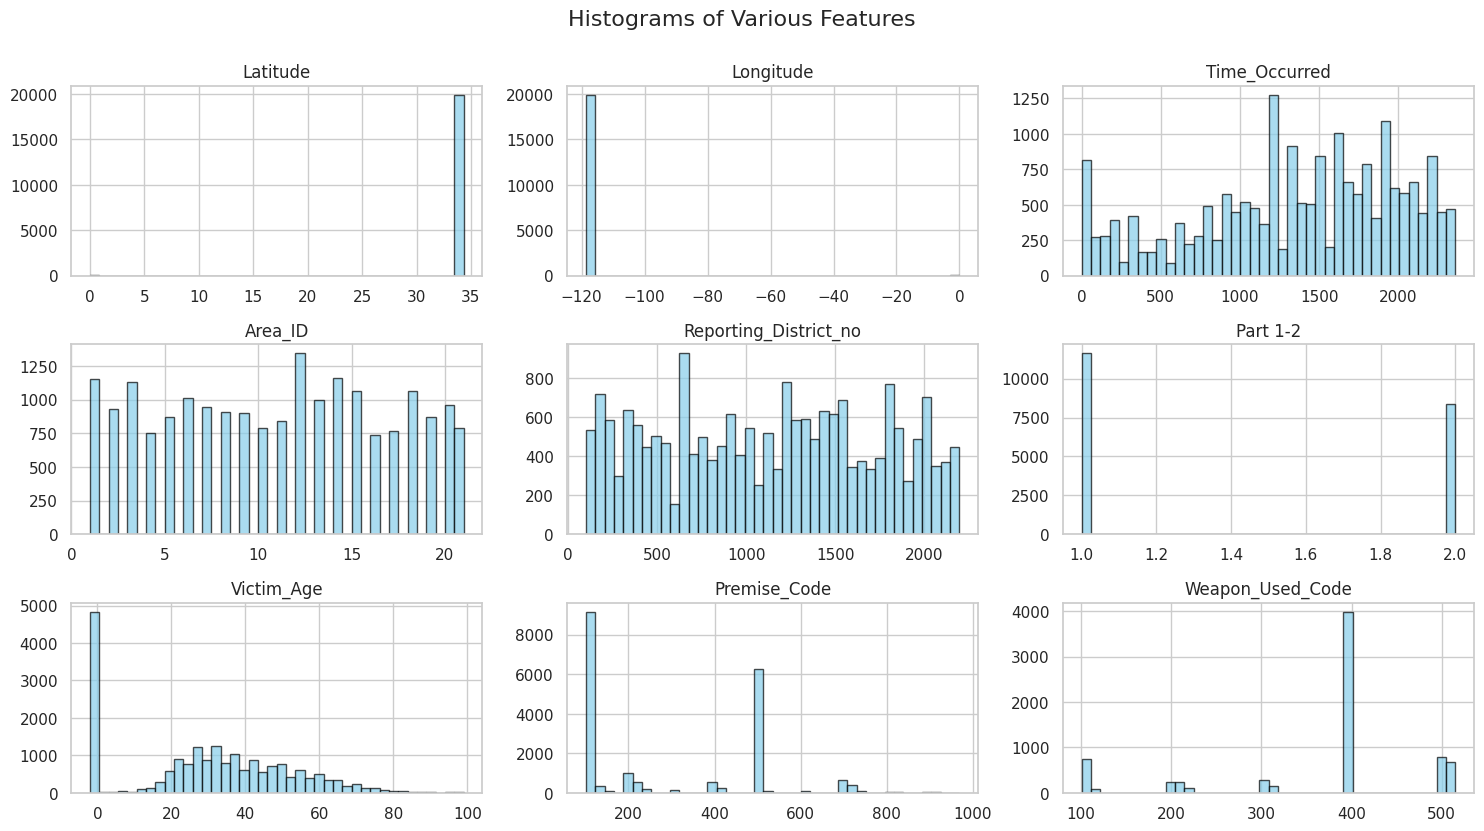

In [8]:
sns.set(style="whitegrid")

# Create histograms with 3 plots per row, adjusting the layout to fit all features
df.hist(figsize=(15, 18), bins=40, edgecolor='black', color='skyblue', alpha=0.7, layout=(7, 3))

# Adjust layout and titles
plt.tight_layout()
plt.suptitle('Histograms of Various Features', fontsize=16, y=1.02)
plt.show()

Inferences:
- Latitude and Longitude: Most crimes are concentrated in a specific - geographic area, as shown by the narrow distribution in both plots.
- Time_Occurred: There's a higher frequency of crimes during certain hours, with peaks visible in the histogram.
- Victim_Age: The distribution is right-skewed, with most victims being younger (between 20-40 years old approximately). However there seems to be 0 and negative Ages, which is not correct.
- Premise_Code: Some premise codes are much more common than others, indicating certain locations are more prone to crime.

## Feature Extraction for DateTime

In [9]:
df['Date_Reported'] = pd.to_datetime(df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p')
df['Date_Occurred'] = pd.to_datetime(df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p')

def extract_datetime_features(df):
    df = df.copy()
    df['Year_Reported'] = df['Date_Reported'].dt.year
    df['Month_Reported'] = df['Date_Reported'].dt.month
    df['Day_Reported'] = df['Date_Reported'].dt.day
    df['DayOfWeek_Reported'] = df['Date_Reported'].dt.dayofweek
    df['Hour_Reported'] = df['Date_Reported'].dt.hour

    df['Year_Occurred'] = df['Date_Occurred'].dt.year
    df['Month_Occurred'] = df['Date_Occurred'].dt.month
    df['Day_Occurred'] = df['Date_Occurred'].dt.day
    df['DayOfWeek_Occurred'] = df['Date_Occurred'].dt.dayofweek
    df['Hour_Occurred'] = df['Date_Occurred'].dt.hour

    return df

df = extract_datetime_features(df.copy())

Filtering Data with Numerical features only

In [10]:
numerical_feats = df.select_dtypes(include=['int64', 'float64'])

### BoxPlots to check for Outliers

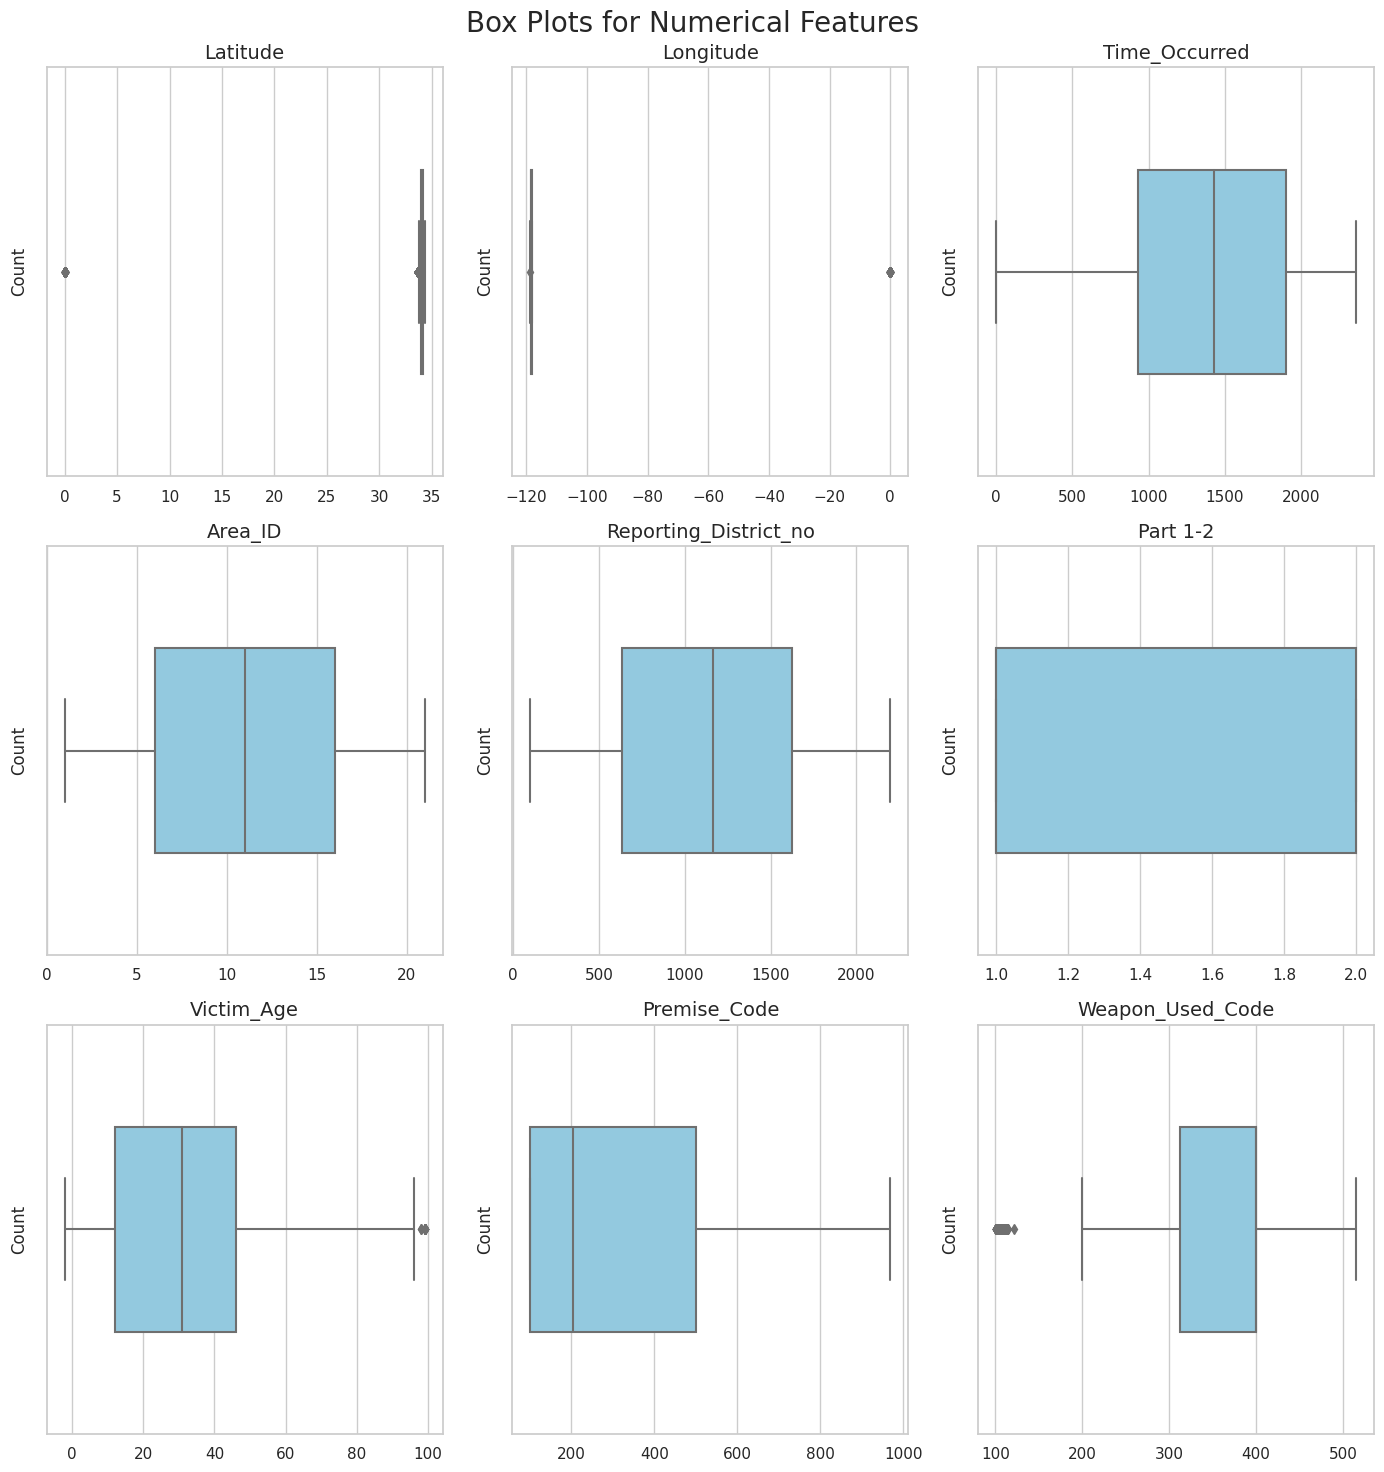

In [11]:
# Set up subplots for box plots
fig, axes = plt.subplots(3, 3, figsize=(14, 15))
axes = axes.ravel()

# Plotting box plots for each numerical feature
for i, column in enumerate(numerical_feats):
    sns.boxplot(x=column, data=df, color='skyblue', width=0.5, fliersize=5, ax=axes[i])
    axes[i].set_title(f'{column}', fontsize=14)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('Count', fontsize=12)
plt.suptitle('Box Plots for Numerical Features', fontsize=20)
plt.tight_layout()
plt.show()

## Violin plots for numerical features to show the distribution of data

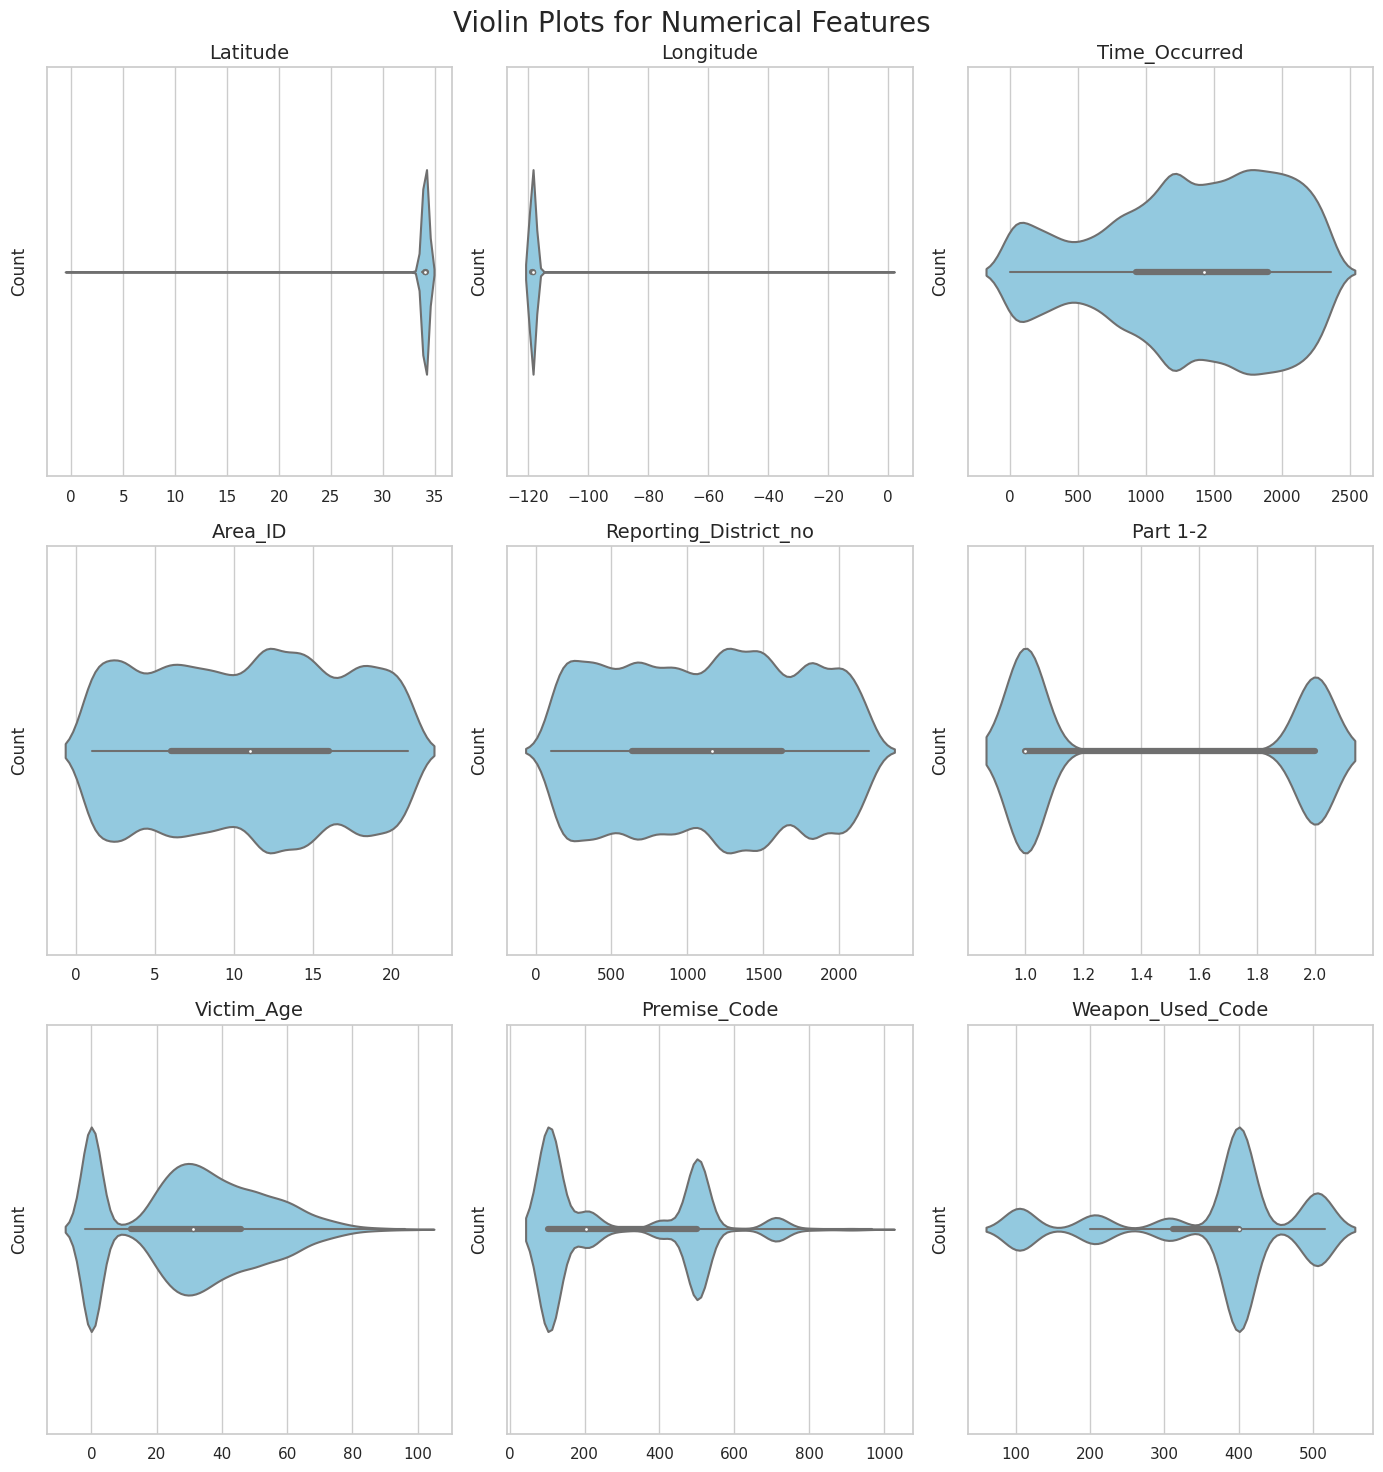

In [12]:
# Set up subplots for box plots
fig, axes = plt.subplots(3, 3, figsize=(14, 15))

# Flatten the axes for easy iteration
axes = axes.ravel()

# Iterate through numeric columns and create box plots
for i, column in enumerate(numerical_feats):
    sns.violinplot(x=column, data=df, color='skyblue', width=0.5, fliersize=5, ax=axes[i])
    axes[i].set_title(f'{column}', fontsize=14)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('Count', fontsize=12)
plt.suptitle('Violin Plots for Numerical Features', fontsize=20)
plt.tight_layout()
plt.show()

Potential outliers: Latitude & Longitude show potential outliers

### Crime frequency by month

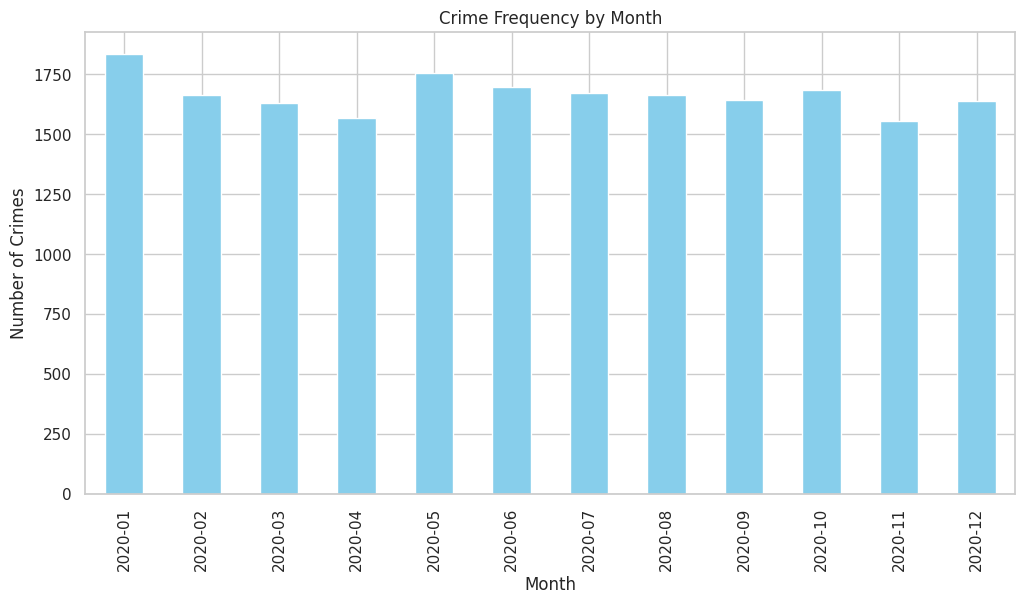

In [13]:
plt.figure(figsize=(12, 6))
df['Date_Occurred'].dt.to_period('M').value_counts().sort_index().plot(color='skyblue',kind='bar')
plt.title('Crime Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.show()

### Crime frequency by day of week

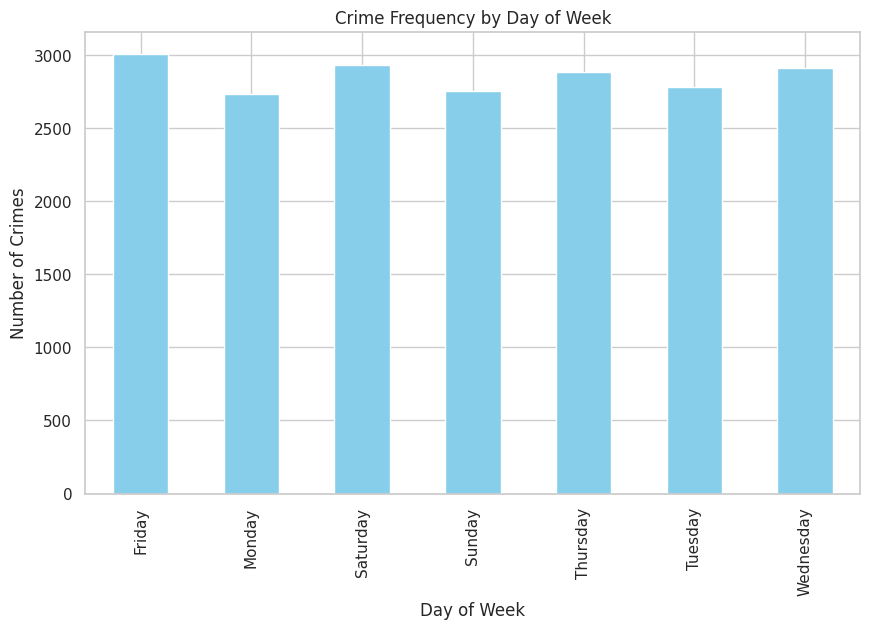

In [14]:
color='skyblue', plt.figure(figsize=(10, 6))
df['Date_Occurred'].dt.day_name().value_counts().sort_index().plot(color='skyblue', kind='bar')
plt.title('Crime Frequency by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Crimes')
plt.show()


### Crime density by Area_Name

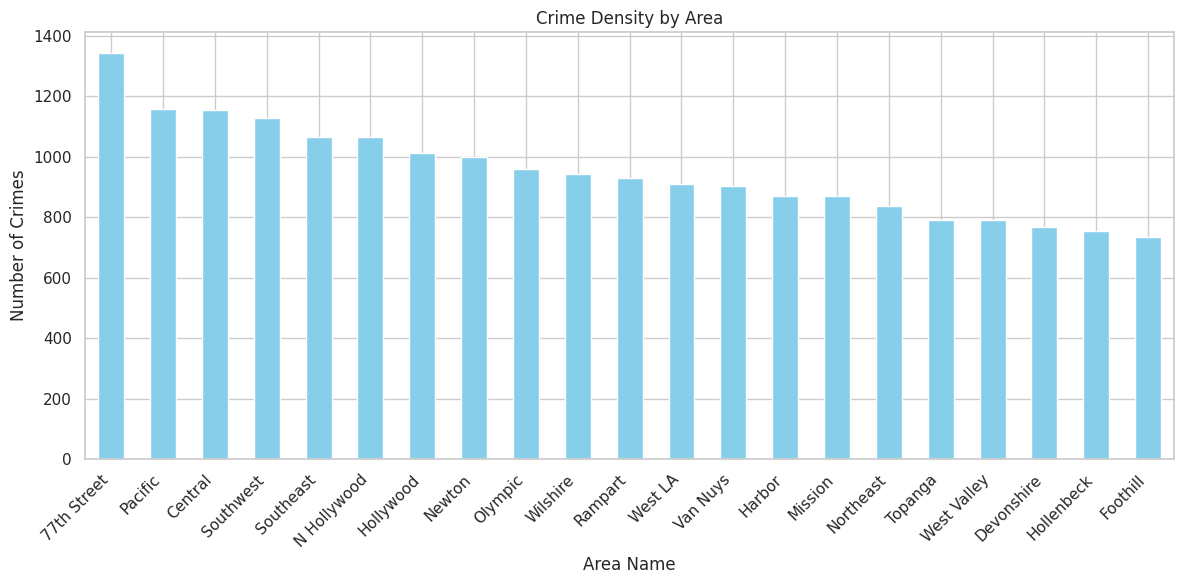

In [15]:
plt.figure(figsize=(12, 6))
df['Area_Name'].value_counts().plot(color='skyblue', kind='bar')
plt.title('Crime Density by Area')
plt.xlabel('Area Name')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Distribution of Categorical Features Values Including Target that is Crime Category

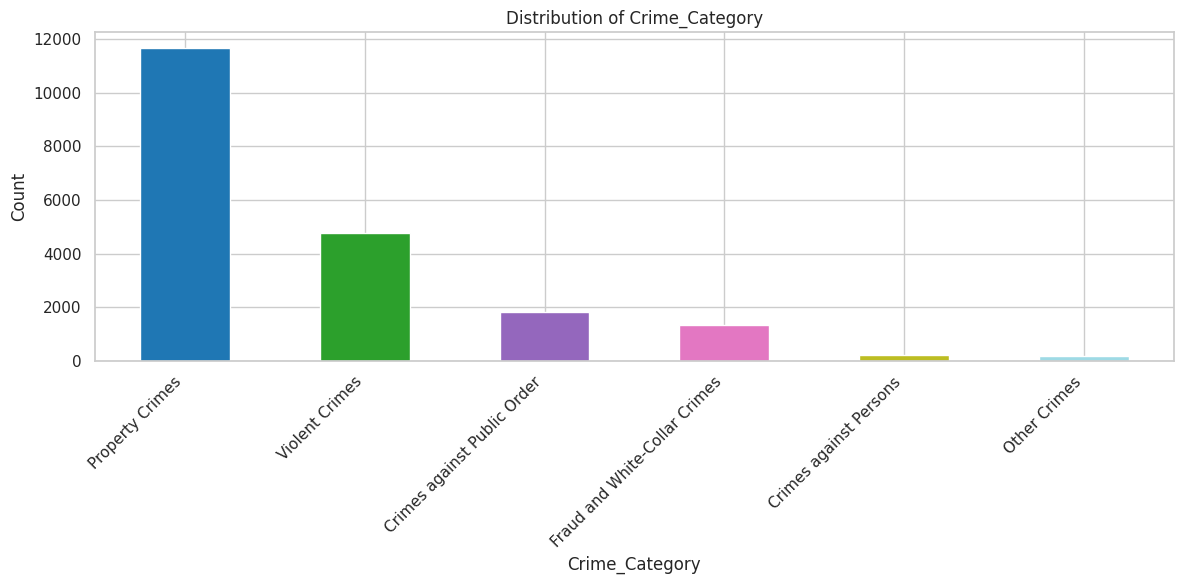

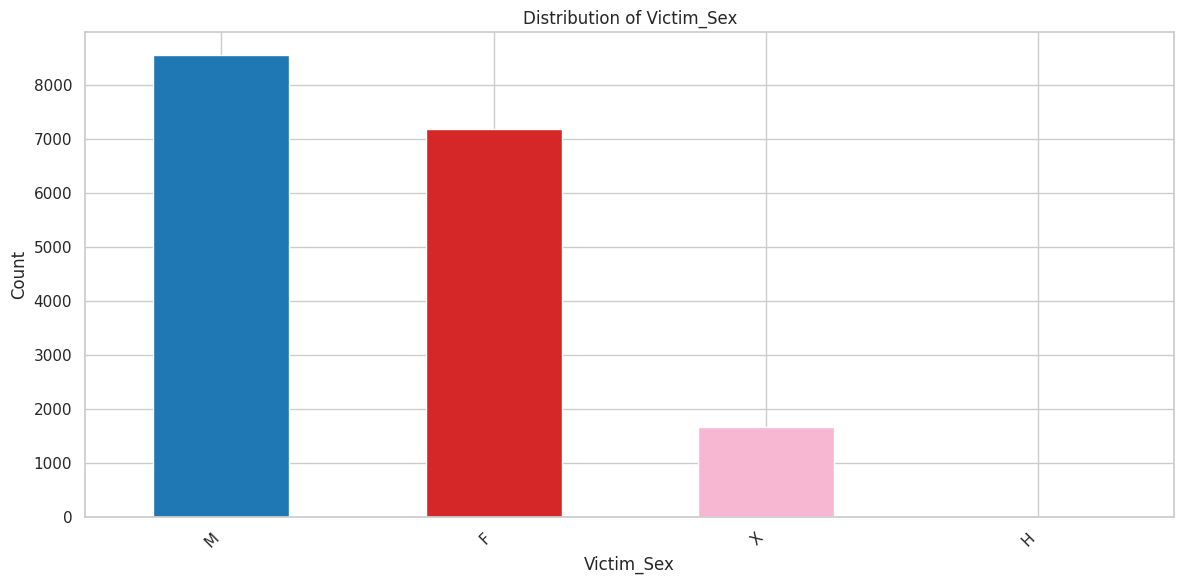

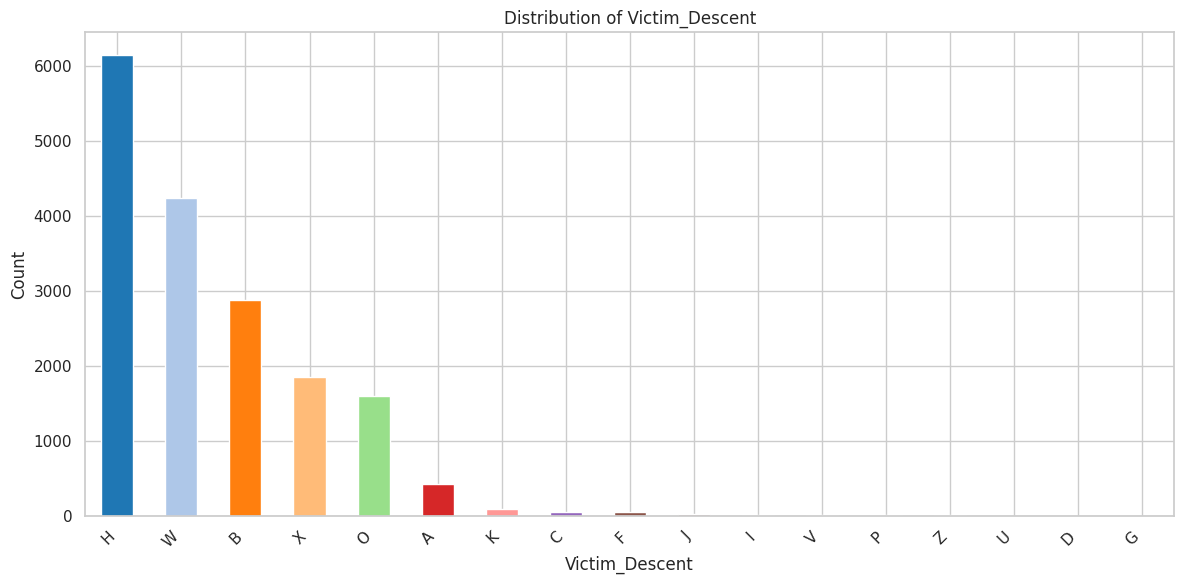

In [16]:
categorical_vars = ['Crime_Category', 'Victim_Sex', 'Victim_Descent']

for var in categorical_vars:
    # Get counts of each category
    counts = df[var].value_counts()
    
    # Generate a color map with a distinct color for each category
    colors = plt.cm.tab20(np.linspace(0, 1, len(counts)))
    
    # Create bar plot with different colors for each bar
    plt.figure(figsize=(12, 6))
    counts.plot(kind='bar', color=colors)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## Stacked bar chart for Crime_Category vs. Victim_Sex


<Figure size 1200x600 with 0 Axes>

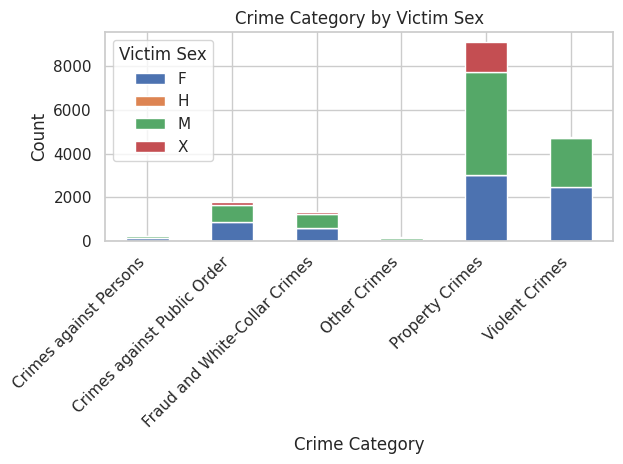

In [17]:
plt.figure(figsize=(12, 6))
df.groupby(['Crime_Category', 'Victim_Sex']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Crime Category by Victim Sex')
plt.xlabel('Crime Category')
plt.ylabel('Count')
plt.legend(title='Victim Sex')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Correlation Matrix

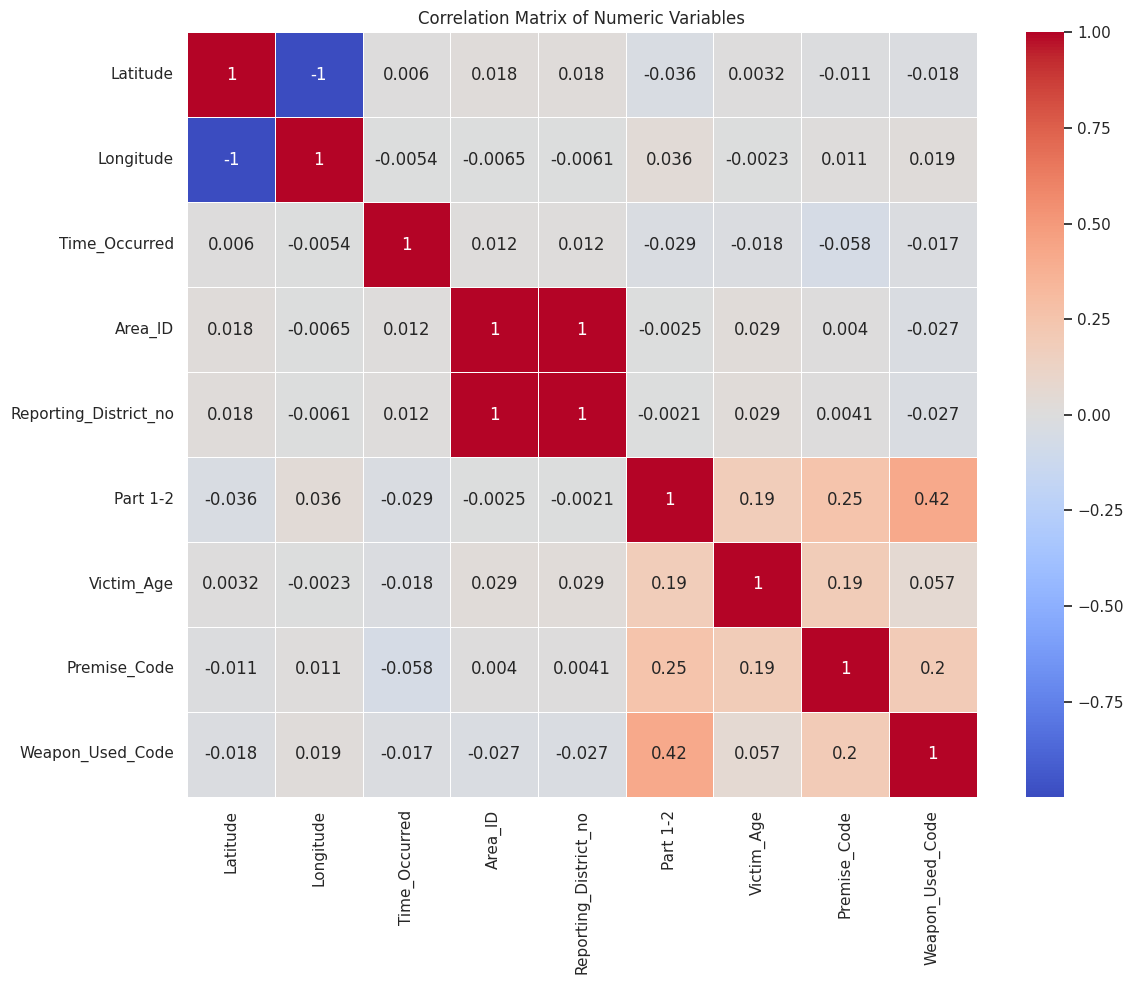

In [18]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()

## % of Missing Data

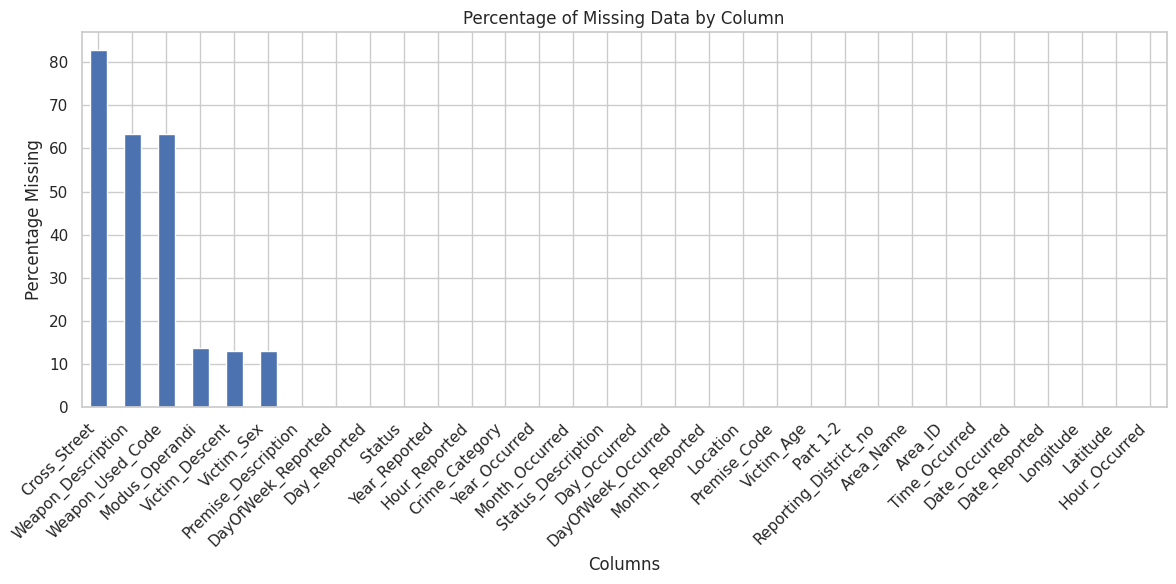

In [19]:
# Calculate percentage of missing values
missing_percentages = df.isnull().mean() * 100

# Create bar plot
plt.figure(figsize=(12, 6))
missing_percentages.sort_values(ascending=False).plot(kind='bar')
plt.title('Percentage of Missing Data by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Cross_Street, Weapon_Description & Weapon_User_Code has >50% Missing Data

## Victim Demographics: Age, Sex, and Descent

<Figure size 1200x600 with 0 Axes>

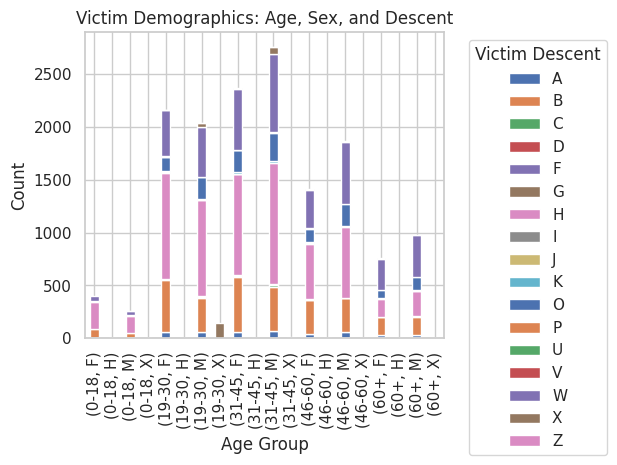

In [20]:
# Create age bins
df['Age_Group'] = pd.cut(df['Victim_Age'], bins=[0, 18, 30, 45, 60, 100], labels=['0-18', '19-30', '31-45', '46-60', '60+'])

# Create grouped bar chart
plt.figure(figsize=(12, 6))
df.groupby(['Age_Group', 'Victim_Sex'])['Victim_Descent'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Victim Demographics: Age, Sex, and Descent')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Victim Descent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Distribution of Case Status

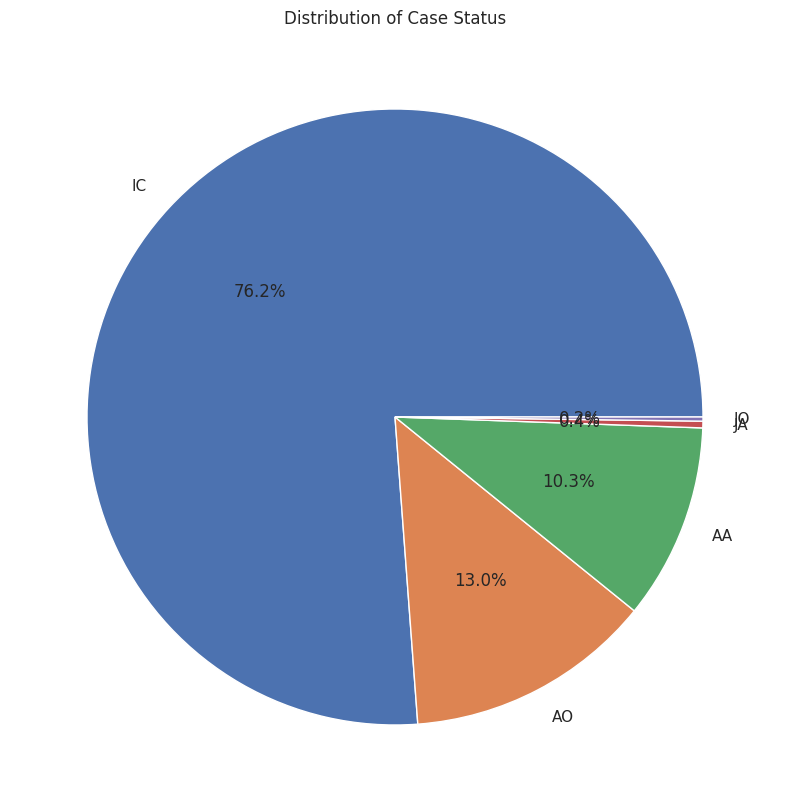

In [21]:
# Create pie chart of case Status
plt.figure(figsize=(10, 10))
df['Status'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Case Status')
plt.ylabel('')
plt.show()

## Top 15 Crime Locations

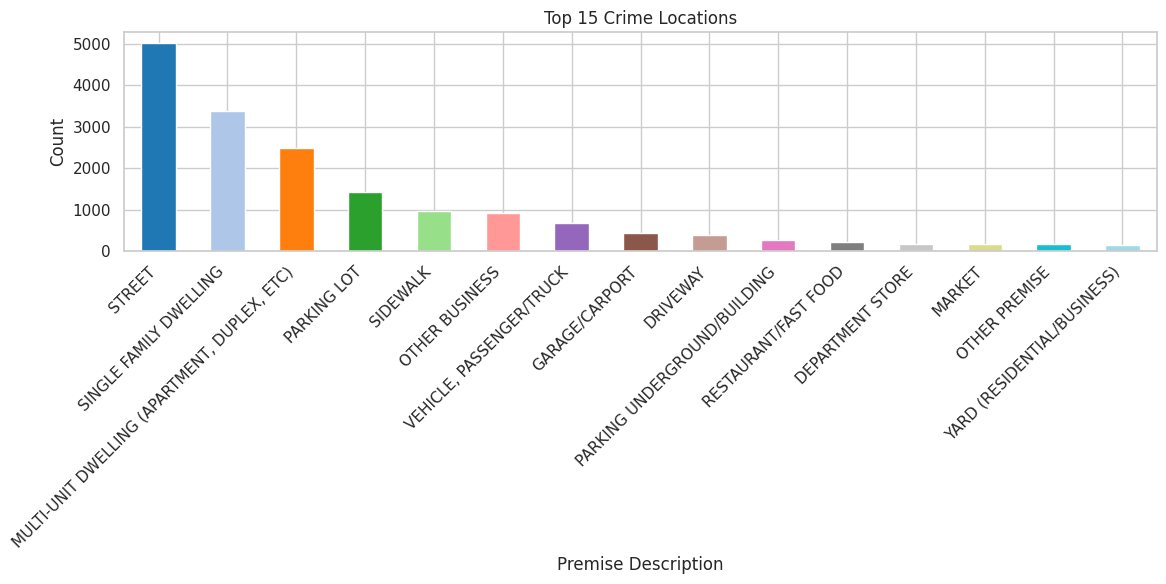

In [22]:
crime_counts = df['Premise_Description'].value_counts().nlargest(15)

# Generate a color map with a distinct color for each category
colors = plt.cm.tab20(np.linspace(0, 1, len(crime_counts)))

# Create bar plot with different colors for each bar
plt.figure(figsize=(12, 6))
crime_counts.plot(kind='bar', color=colors)
plt.title('Top 15 Crime Locations')
plt.xlabel('Premise Description')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Distribution of Victim Sex

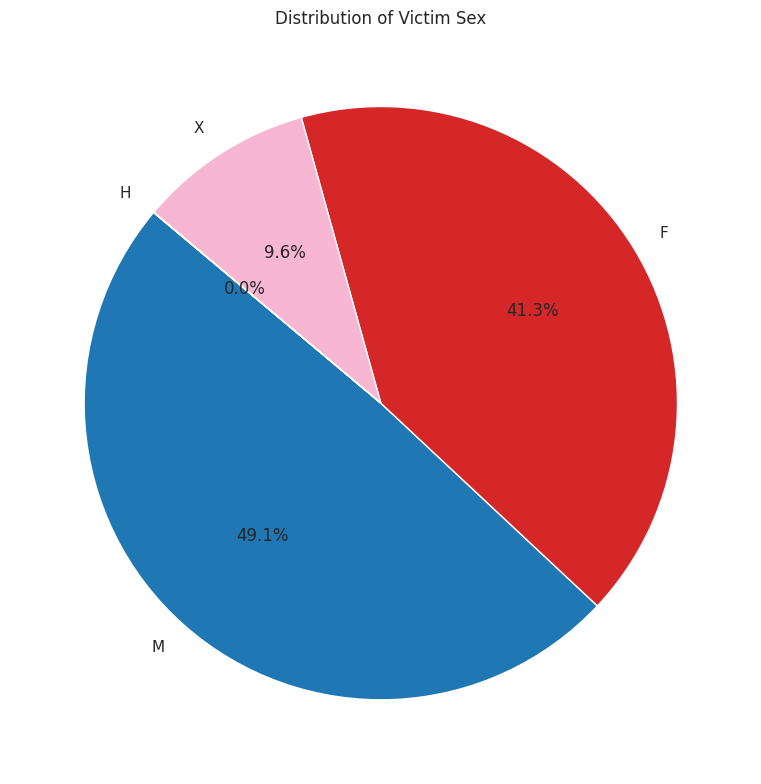

In [23]:
# Get the counts of each category
victim_sex_counts = df['Victim_Sex'].value_counts()

# Generate a color map with a distinct color for each category
colors = plt.cm.tab20(np.linspace(0, 1, len(victim_sex_counts)))

# Create pie chart with different colors for each segment
plt.figure(figsize=(8, 8))
plt.pie(victim_sex_counts, labels=victim_sex_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Victim Sex')
plt.tight_layout()
plt.show()


## Removing Outlier for a better understanding of Correlation

In [24]:
df = df[(df['Latitude'] != 0) & (df['Longitude'] != 0)]

## Correlation Matrix with Target Feature

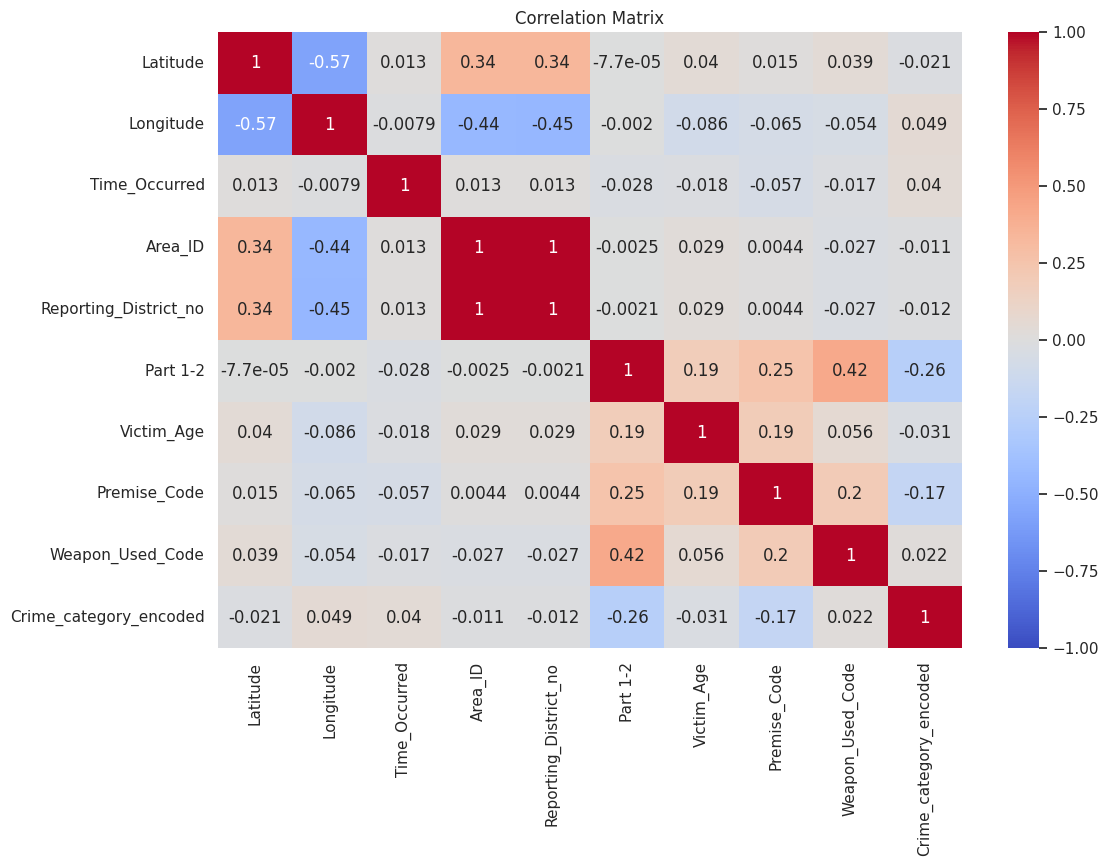

In [25]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Encode the target variable
label_encoder = LabelEncoder()
df['Crime_category_encoded'] = label_encoder.fit_transform(df['Crime_Category'])

# Compute the correlation matrix
correlation_matrix = df[numerical_features + ['Crime_category_encoded']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Feature Engineering &  Data Processing

In [26]:
def process_data(df):
    # Handling Null Values
    df['Victim_Sex'] = df['Victim_Sex'].fillna('U')
    df['Victim_Descent'] = df['Victim_Descent'].fillna('0')
    df['Weapon_Used_Code'] = df['Weapon_Used_Code'].fillna(0)

    # Processing Date and Time
    df['Date_Reported'] = pd.to_datetime(df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p')
    df['Date_Occurred'] = pd.to_datetime(df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p')

    df['Year_Reported'] = df['Date_Reported'].dt.year
    df['Month_Reported'] = df['Date_Reported'].dt.month
    df['Day_Reported'] = df['Date_Reported'].dt.day
    df['DayOfWeek_Reported'] = df['Date_Reported'].dt.dayofweek

    df['Year_Occurred'] = df['Date_Occurred'].dt.year
    df['Month_Occurred'] = df['Date_Occurred'].dt.month
    df['Day_Occurred'] = df['Date_Occurred'].dt.day
    df['DayOfWeek_Occurred'] = df['Date_Occurred'].dt.dayofweek

    df['Days_InBetween'] = (df['Date_Reported'] - df['Date_Occurred']).dt.days
    df['Total_InBetween'] = (df['Date_Reported'] - df['Date_Occurred'])
    df['Total_InBetween_Seconds'] = df['Total_InBetween'].dt.total_seconds()

    def convert_to_datetime(time):
        # Ensure the time is represented as a four-digit string, e.g., 900 -> '0900'
        time_str = str(int(time)).zfill(4)
        return pd.to_datetime(time_str, format='%H%M')

    df['Time_Occurred_Datetime'] = df['Time_Occurred'].apply(convert_to_datetime)

    df['Hour'] = df['Time_Occurred_Datetime'].dt.hour
    df['Minute'] = df['Time_Occurred_Datetime'].dt.minute

    # Categorize time into parts of the day
    def categorize_time(hour):
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'

    df['Time_of_Day'] = df['Hour'].apply(categorize_time)

    # Calculate minutes since start of the day
    df['Minutes_Since_Midnight'] = df['Hour'] * 60 + df['Minute']

    # Handle Negative and 0 Ages
    df['Victim_Age_Proper'] = df['Victim_Age'].apply(lambda x: 0 if x <= 0 else 1)
    df.loc[df['Victim_Age'] <= 0, 'Victim_Age'] = np.nan
    df['Victim_Age'] = df['Victim_Age'].fillna(0)

    df['Is_CrossStreet'] = df['Cross_Street'].apply(lambda x: 0 if x == 0 else 1)

    # Calculate distance to a central point (e.g., City Center)
    city_center = (34.0522, -118.2437)  # Coordinates of Los Angeles City Center
    df['Distance_to_City_Center'] = np.sqrt((df['Latitude'] - city_center[0])**2 + (df['Longitude'] - city_center[1])**2)

    # Week of the Year
    df['Week_Reported'] = df['Date_Reported'].dt.isocalendar().week
    df['Week_Occurred'] = df['Date_Occurred'].dt.isocalendar().week

    # Is Weekend
    df['Is_Weekend_Reported'] = df['DayOfWeek_Reported'].apply(lambda x: 1 if x >= 5 else 0)
    df['Is_Weekend_Occurred'] = df['DayOfWeek_Occurred'].apply(lambda x: 1 if x >= 5 else 0)

    # Hour Bins
    df['Hour_Bin'] = pd.cut(df['Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

    # Victim Age Group
    def age_group(age):
        if age < 13:
            return 'Child'
        elif 13 <= age < 20:
            return 'Teen'
        elif 20 <= age < 60:
            return 'Adult'
        else:
            return 'Senior'

    df['Victim_Age_Group'] = df['Victim_Age'].apply(age_group)

    # Modus_Operandi Count
    df['Modus_Operandi_Count'] = df['Modus_Operandi'].apply(lambda x: len(str(x).split()))

    # Elapsed Time Categories
    def elapsed_time_category(days):
        if days == 0:
            return 'Same Day'
        elif 1 <= days <= 3:
            return '1-3 Days'
        else:
            return 'More than 3 Days'

    df['Elapsed_Time_Category'] = df['Days_InBetween'].apply(elapsed_time_category)

    
    # Dropping Features that are not Useful
    drop_cols = ['Date_Reported', 'Date_Occurred', 'Time_Occurred', 'Time_Occurred_Datetime', 'Location', 'Cross_Street', 'Premise_Description', 'Status_Description', 'Weapon_Description']
    # Description Features are Redundant. Cross_Street is >50% missing. Location is uniquely identified by Longitude and Latitude.

    df.drop(columns=drop_cols, inplace=True)

    return df

In [27]:
train_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

In [28]:
train_df.shape

(20000, 22)

In [29]:
test_df.shape

(5000, 21)

In [30]:
train_df = process_data(train_df)
test_df = process_data(test_df)

In [31]:
train_df.head(5).T

,0,1,2,3,4
Latitude,34.1522,34.0028,34.0111,34.2953,33.9787
Longitude,-118.391,-118.2391,-118.2653,-118.459,-118.2918
Area_ID,15.0,13.0,13.0,19.0,12.0
Area_Name,N Hollywood,Newton,Newton,Mission,77th Street
Reporting_District_no,1563.0,1367.0,1343.0,1924.0,1245.0
Part 1-2,1.0,1.0,2.0,1.0,1.0
Modus_Operandi,0385,0906 0352 0371 0446 1822 0344 0416 0417,0329 1202,0329 1300,0416 0945 1822 0400 0417 0344
Victim_Age,75.0,41.0,67.0,61.0,0.0
Victim_Sex,M,M,M,M,X
Victim_Descent,W,H,B,H,X


In [32]:
# Replace null values with empty strings
train_df['Modus_Operandi'] = train_df['Modus_Operandi'].fillna('')
test_df['Modus_Operandi'] = test_df['Modus_Operandi'].fillna('')

# Split the 'Modus_Operandi' column into lists of codes
train_df['Modus_Operandi'] = train_df['Modus_Operandi'].apply(lambda x: x.split())
test_df['Modus_Operandi'] = test_df['Modus_Operandi'].apply(lambda x: x.split())

# Combine the Modus_Operandi codes from both train and test sets to fit the MultiLabelBinarizer
all_modus_operandi = pd.concat([train_df['Modus_Operandi'], test_df['Modus_Operandi']])

# Perform One-Hot Encoding using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(all_modus_operandi)

# Transform the training and test sets separately
train_encoded = mlb.transform(train_df['Modus_Operandi'])
test_encoded = mlb.transform(test_df['Modus_Operandi'])

# Create DataFrames with the encoded columns
train_encoded_df = pd.DataFrame(train_encoded, columns=mlb.classes_)
test_encoded_df = pd.DataFrame(test_encoded, columns=mlb.classes_)

# Concatenate the encoded columns with the original DataFrames
train_df = pd.concat([train_df, train_encoded_df], axis=1).drop(columns=['Modus_Operandi'])
test_df = pd.concat([test_df, test_encoded_df], axis=1).drop(columns=['Modus_Operandi'])


In [33]:
train_df.head()

,Latitude,Longitude,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,...,2204,2208,2303,2304,2308,3003,3004,3030,4025,9999
0,34.1522,-118.3910,15.0,N Hollywood,1563.0,1.0,75.0,M,W,101.0,...,0,0,0,0,0,0,0,0,0,0
1,34.0028,-118.2391,13.0,Newton,1367.0,1.0,41.0,M,H,216.0,...,0,0,0,0,0,0,0,0,0,0
2,34.0111,-118.2653,13.0,Newton,1343.0,2.0,67.0,M,B,501.0,...,0,0,0,0,0,0,0,0,0,0
3,34.2953,-118.4590,19.0,Mission,1924.0,1.0,61.0,M,H,101.0,...,0,0,0,0,0,0,0,0,0,0
4,33.9787,-118.2918,12.0,77th Street,1245.0,1.0,0.0,X,X,401.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
none_empty_counts_per_column = train_df.apply(lambda x: x.isna().sum() + (x == '').sum())
print(f"Total Empty Values: {none_empty_counts_per_column.sum()}")
none_empty_counts_per_column

Total Empty Values: 0


Latitude                 0
Longitude                0
Area_ID                  0
Area_Name                0
Reporting_District_no    0
                        ..
3003                     0
3004                     0
3030                     0
4025                     0
9999                     0
Length: 538, dtype: int64

In [35]:
print(train_df.shape)
print(test_df.shape)

(20000, 538)
(5000, 537)


## Removing Outlier

In [36]:
train_df = train_df[(train_df['Latitude'] != 0) & (train_df['Longitude'] != 0)]

In [37]:
train_df.shape

(19922, 538)

In [38]:
X = train_df.drop('Crime_Category', axis = 1)
y = train_df['Crime_Category']

## Train test split with 20% data in Validation Set

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [40]:
print(X_train.shape)
print(X_val.shape)

(15937, 537)
(3985, 537)


In [41]:
X_test = test_df
X_test.shape

(5000, 537)

# Baseline Dummy Classifier

In [42]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state = 42)

# Fit the classifier on the training data
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_val)
print('Accuracy on Validation Data:')
print(accuracy_score(dummy_pred, y_val))

Accuracy on Validation Data:
0.5992471769134253


In [43]:
# Initialize lists for numerical and categorical features
numerical_features = []
categorical_features = []

# Classify columns based on their data types
for column, dtype in X_train.dtypes.items():
    if pd.api.types.is_numeric_dtype(dtype):
        numerical_features.append(column)
    else:
        categorical_features.append(column)
        
print('Numerical Features: ', numerical_features[:25])
print('Categorical Features: ', categorical_features[:10])

Numerical Features:  ['Latitude', 'Longitude', 'Area_ID', 'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code', 'Weapon_Used_Code', 'Year_Reported', 'Month_Reported', 'Day_Reported', 'DayOfWeek_Reported', 'Year_Occurred', 'Month_Occurred', 'Day_Occurred', 'DayOfWeek_Occurred', 'Days_InBetween', 'Total_InBetween_Seconds', 'Hour', 'Minute', 'Minutes_Since_Midnight', 'Victim_Age_Proper', 'Is_CrossStreet', 'Distance_to_City_Center', 'Week_Reported']
Categorical Features:  ['Area_Name', 'Victim_Sex', 'Victim_Descent', 'Status', 'Total_InBetween', 'Time_of_Day', 'Hour_Bin', 'Victim_Age_Group', 'Elapsed_Time_Category']


In [44]:
# Define preprocessing steps for numerical features
numerical_transformer = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
    ('var_threshold', VarianceThreshold(threshold=0.0)),  # Remove features with zero variance
    ('selectkbest', SelectKBest(score_func=f_regression, k=300))  # Select top 300 features based on f_regression
])

# Define preprocessing steps for categorical features
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features as a one-hot numeric array
])

# Full preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

In [45]:
# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the training labels
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform Validation Set
y_val_encoded = label_encoder.transform(y_val)

# Model: Logistic Regression

In [46]:
# Define the model
model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)

pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

# Fit the Model
pipeline.fit(X_train, y_train_encoded)

# Predict on validation data and print accuracy
val_preds = pipeline.predict(X_val)
val_accuracy = accuracy_score(y_val_encoded, val_preds)
print(f'Validation Accuracy: {val_accuracy}')

# Make Predictions
final_preds_encoded = pipeline.predict(X_test)

# Convert final predictions back to string labels
final_preds = label_encoder.inverse_transform(final_preds_encoded)

# Print final predictions
print("Final Predictions:", final_preds)

Validation Accuracy: 0.9437892095357591
Final Predictions: ['Violent Crimes' 'Property Crimes' 'Fraud and White-Collar Crimes' ...
 'Violent Crimes' 'Violent Crimes' 'Property Crimes']


In [47]:
def evaluate_and_predict(model, param_grid=None):
    # Create the pipeline with dimensionality reduction
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # If param_grid is provided, use GridSearchCV for hyperparameter tuning
    if param_grid is not None:
        grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X_train, y_train_encoded)
        best_pipeline = grid_search.best_estimator_
        print(f'Best Parameters: {grid_search.best_params_}')
    else:
        # If no hyperparameter tuning is required, fit the model directly
        pipeline.fit(X_train, y_train_encoded)
        best_pipeline = pipeline
    
    # Predict on validation data and print accuracy
    val_preds = best_pipeline.predict(X_val)
    val_accuracy = accuracy_score(y_val_encoded, val_preds)
    print(f'Validation Accuracy: {val_accuracy}')
    
    # Predict on test data
    final_preds_encoded = best_pipeline.predict(X_test)
    
    # Convert final predictions back to string labels
    final_preds = label_encoder.inverse_transform(final_preds_encoded)
    
    # Detailed performance evaluation
    print("Detailed Evaluation Metrics:")
    print(f"Precision: {precision_score(y_val_encoded, val_preds, average='weighted')}")
    print(f"Recall: {recall_score(y_val_encoded, val_preds, average='weighted')}")
    print(f"F1 Score: {f1_score(y_val_encoded, val_preds, average='weighted')}")
    
    print("\nClassification Report:")
    print(classification_report(y_val_encoded, val_preds, target_names=label_encoder.classes_))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_val_encoded, val_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    return final_preds, best_pipeline

# Models: KNN, Decision Tree & SGD

Evaluating KNN...
Best Parameters: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Validation Accuracy: 0.8880803011292346
Detailed Evaluation Metrics:
Precision: 0.8840558952624962
Recall: 0.8880803011292346
F1 Score: 0.8850670503682448

Classification Report:
                               precision    recall  f1-score   support

       Crimes against Persons       0.48      0.44      0.46        36
  Crimes against Public Order       0.69      0.73      0.71       313
Fraud and White-Collar Crimes       0.93      0.91      0.92       284
                 Other Crimes       0.17      0.02      0.04        43
              Property Crimes       0.95      0.93      0.94      2388
               Violent Crimes       0.82      0.89      0.85       921

                     accuracy                           0.89      3985
                    macro avg       0.67      0.65      0.65      3985
                 weighted avg       0.88      0.89      0.89      3985


Confus

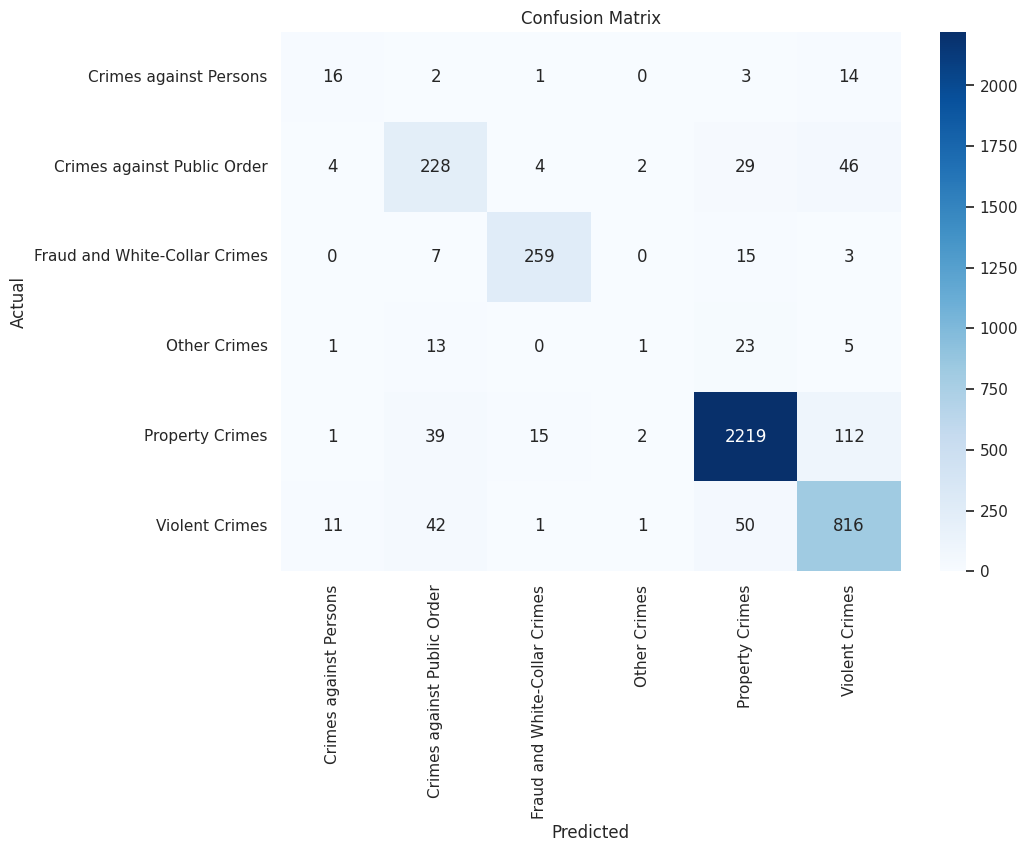

Final Predictions for KNN: ['Violent Crimes' 'Property Crimes' 'Fraud and White-Collar Crimes' ...
 'Violent Crimes' 'Violent Crimes' 'Property Crimes']

Evaluating Decision Tree...
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2}
Validation Accuracy: 0.9478042659974906
Detailed Evaluation Metrics:
Precision: 0.9475565842336745
Recall: 0.9478042659974906
F1 Score: 0.946405641501396

Classification Report:
                               precision    recall  f1-score   support

       Crimes against Persons       0.69      0.50      0.58        36
  Crimes against Public Order       0.81      0.85      0.83       313
Fraud and White-Collar Crimes       0.94      0.91      0.92       284
                 Other Crimes       0.65      0.30      0.41        43
              Property Crimes       1.00      0.97      0.99      2388
               Violent Crimes       0.90      0.97      0.93       921

                     accuracy                           0.

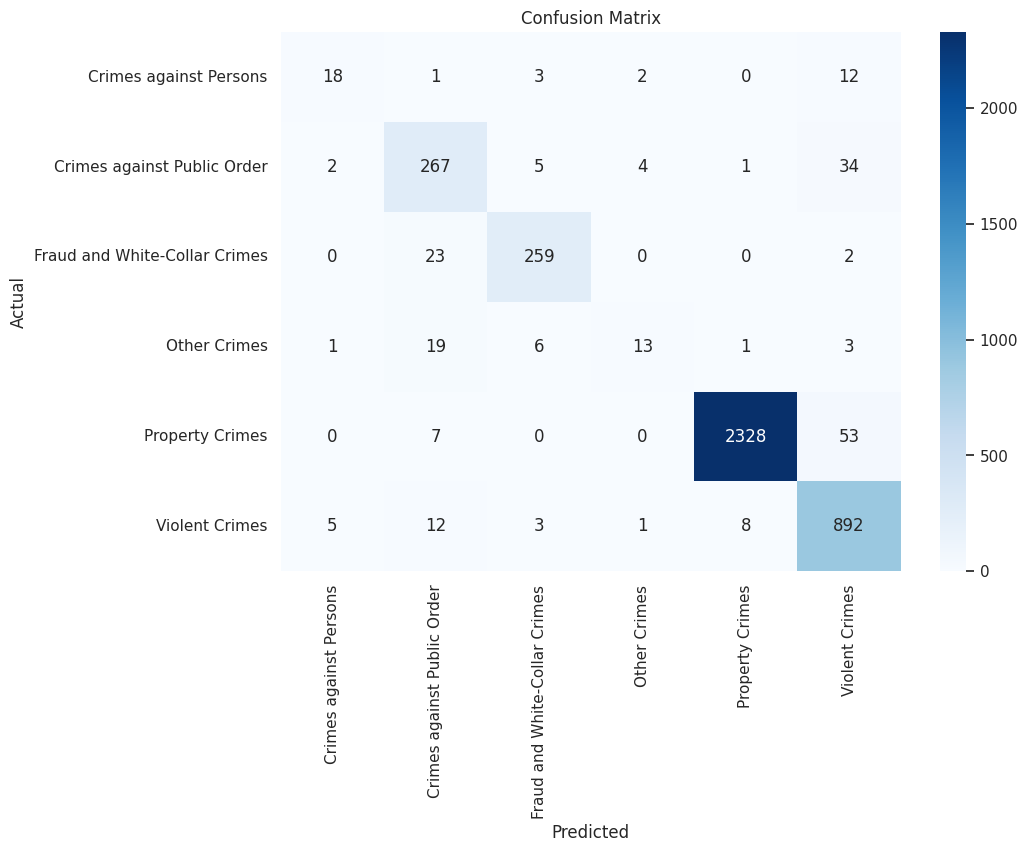

Final Predictions for Decision Tree: ['Violent Crimes' 'Property Crimes' 'Fraud and White-Collar Crimes' ...
 'Violent Crimes' 'Violent Crimes' 'Property Crimes']

Evaluating SGD Classifier...
Best Parameters: {'classifier__alpha': 0.001, 'classifier__loss': 'log_loss'}
Validation Accuracy: 0.9440401505646173
Detailed Evaluation Metrics:
Precision: 0.9420445352236876
Recall: 0.9440401505646173
F1 Score: 0.9402363734757043

Classification Report:
                               precision    recall  f1-score   support

       Crimes against Persons       0.76      0.44      0.56        36
  Crimes against Public Order       0.80      0.84      0.82       313
Fraud and White-Collar Crimes       0.94      0.94      0.94       284
                 Other Crimes       0.71      0.12      0.20        43
              Property Crimes       0.98      0.98      0.98      2388
               Violent Crimes       0.91      0.94      0.93       921

                     accuracy                      

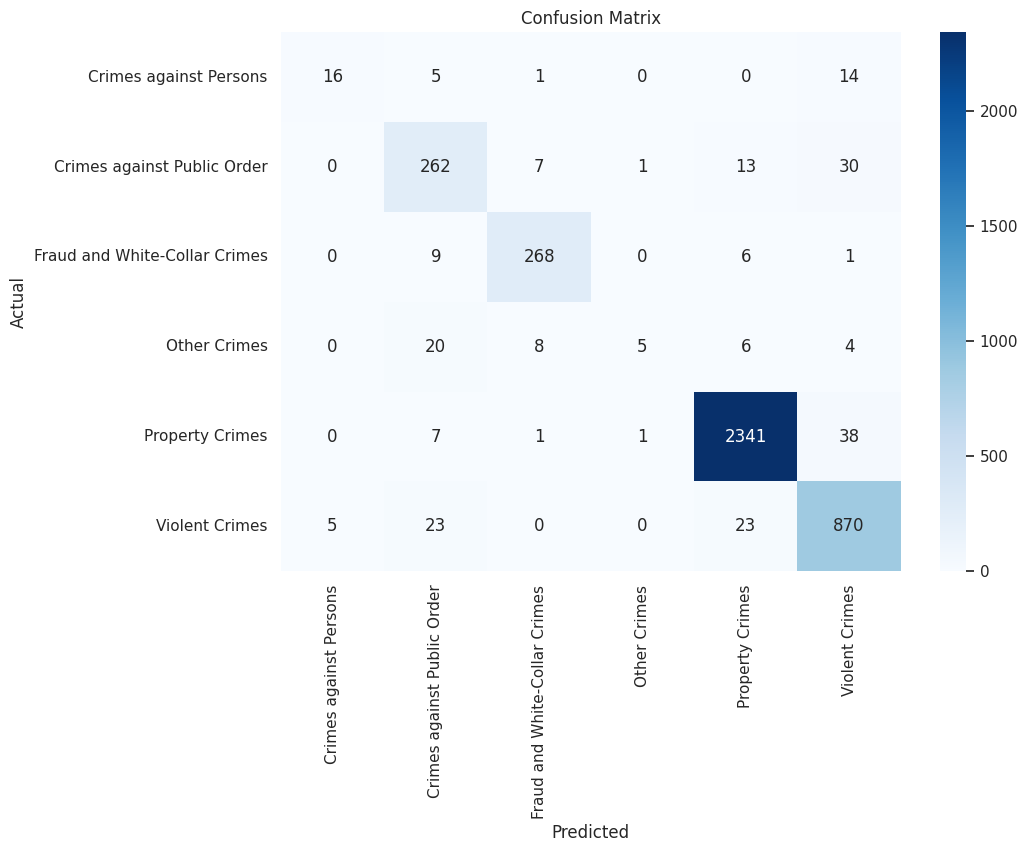

Final Predictions for SGD Classifier: ['Violent Crimes' 'Property Crimes' 'Fraud and White-Collar Crimes' ...
 'Violent Crimes' 'Violent Crimes' 'Property Crimes']



In [48]:
# Define models and parameter grids for logistic regression, KNN, and decision tree
models_param_grids = {
    'KNN': (KNeighborsClassifier(), {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
    }),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
    }), 
    'SGD Classifier': (SGDClassifier(max_iter=1000, tol=1e-3, random_state=42), {
        'classifier__loss': ['hinge', 'log_loss'],
        'classifier__alpha': [0.001, 0.01],
    })
}

# Loop through the selected models and evaluate
for model_name, (model, param_grid) in models_param_grids.items():
    print(f'Evaluating {model_name}...')
    final_predictions, best_pipeline = evaluate_and_predict(model, param_grid)
    print(f'Final Predictions for {model_name}: {final_predictions}\n')

# Model Comparison and Evaluation Report

## Overview
This report compares the performance of three machine learning models: K-Nearest Neighbors (KNN), Decision Tree, and Stochastic Gradient Descent (SGD) Classifier on a crime classification task.

## Models and Hyperparameters

### KNN
- Best Parameters: n_neighbors=7, weights='distance'
- Hyperparameter Search:
  - n_neighbors: [3, 5, 7]
  - weights: ['uniform', 'distance']

### Decision Tree
- Best Parameters: max_depth=10, min_samples_split=2
- Hyperparameter Search:
  - max_depth: [None, 10, 20]
  - min_samples_split: [2, 5, 10]

### SGD Classifier
- Best Parameters: alpha=0.001, loss='log_loss'
- Hyperparameter Search:
  - loss: ['hinge', 'log_loss']
  - alpha: [0.001, 0.01]

## Performance Metrics

| Model         | Accuracy | Precision | Recall | F1 Score |
|---------------|----------|-----------|--------|----------|
| KNN           | 0.8881   | 0.8841    | 0.8881 | 0.8851   |
| Decision Tree | 0.9478   | 0.9476    | 0.9478 | 0.9464   |
| SGD Classifier| 0.9440   | 0.9420    | 0.9440 | 0.9402   |


## Analysis and Inferences

1. Overall Performance:
   - The Decision Tree model outperforms both KNN and SGD Classifier in terms of accuracy, precision, recall, and F1 score.
   - All models perform well, with accuracies above 88%.

2. Class-specific Performance:
   - All models struggle with the "Other Crimes" and "Crimes against Persons" categories, likely due to class imbalance.
   - The models perform best on "Property Crimes" and "Violent Crimes", which have the largest support.

3. Model Strengths:
   - KNN: Good overall performance, balanced across classes.
   - Decision Tree: Best overall performance, especially good at identifying Property Crimes.
   - SGD Classifier: Strong performance, particularly good at identifying Fraud and White-Collar Crimes.

4. Inferences:
   - Use the Decision Tree model as the primary classifier due to its superior overall performance.
   - Consider ensemble methods or boosting algorithms to further improve performance.
   - Address class imbalance.
   - Fine-tune hyperparameters further, especially for the Decision Tree model, to potentially improve performance.

# LGBM Trained on Full Data: 

In [49]:
# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the training labels
y_train_encoded_full = label_encoder.fit_transform(y)


def evaluate_and_predict_final(model, param_grid=None):
    # Create the pipeline with dimensionality reduction
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # If param_grid is provided, use GridSearchCV for hyperparameter tuning
    if param_grid is not None:
        grid_search = RandomizedSearchCV(pipeline, param_grid, cv=3, verbose=1, n_jobs=-1, random_state=42)
        grid_search.fit(X, y_train_encoded_full)
        best_pipeline = grid_search.best_estimator_
        print(f'Best Parameters: {grid_search.best_params_}')
    else:
        # If no hyperparameter tuning is required, fit the model directly
        pipeline.fit(X, y_train_encoded_full)
        best_pipeline = pipeline
    
    
    # Predict on test data
    final_preds_encoded = best_pipeline.predict(X_test)
    
    # Convert final predictions back to string labels
    final_preds = label_encoder.inverse_transform(final_preds_encoded)
    
    return final_preds

In [50]:
# Define models and parameter grids
models_param_grids = {
    'LightGBM': (LGBMClassifier(verbose=-1, random_state = 42), {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [31, 40, 50],
        'classifier__max_depth': [-1, 10, 20],
        'classifier__min_child_samples': [20, 30, 40],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0]
    })
}

# Loop through models and evaluate
for model_name, (model, param_grid) in models_param_grids.items():
    print(f'Evaluating {model_name}...')
    final_predictions = evaluate_and_predict_final(model, param_grid)
    print(f'Final Predictions for {model_name}: {final_predictions}\n')

Evaluating LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'classifier__subsample': 0.8, 'classifier__num_leaves': 31, 'classifier__n_estimators': 200, 'classifier__min_child_samples': 40, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 1.0}
Final Predictions for LightGBM: ['Violent Crimes' 'Property Crimes' 'Fraud and White-Collar Crimes' ...
 'Violent Crimes' 'Violent Crimes' 'Property Crimes']



Evaluating LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'classifier__subsample': 0.8, 'classifier__num_leaves': 31, 'classifier__n_estimators': 200, 'classifier__min_child_samples': 40, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 1.0}
Final Predictions for LightGBM: ['Violent Crimes' 'Property Crimes' 'Fraud and White-Collar Crimes' ...
 'Violent Crimes' 'Violent Crimes' 'Property Crimes']

# Best Validation Score: 

## Outliers Removal

In [51]:
Q1 = train_df['Victim_Age'].quantile(0.25)
Q3 = train_df['Victim_Age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 +  1.5 * IQR
train_df= train_df[(train_df['Victim_Age'] > lower_bound) & (train_df['Victim_Age'] < upper_bound)]
train_df.shape

(19909, 538)

In [52]:
Q1 = train_df['Latitude'].quantile(0.25)
Q3 = train_df['Latitude'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 +  1.5 * IQR
train_df = train_df[(train_df['Latitude'] > lower_bound) & (train_df['Latitude'] < upper_bound)]
train_df.shape

(19449, 538)

In [53]:
X = train_df.drop('Crime_Category', axis = 1)
y = train_df['Crime_Category']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [54]:
X_train.shape

(15559, 537)

In [55]:
X_test.shape

(5000, 537)

In [56]:
# Define preprocessing steps for numerical features
numerical_transformer = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
    ('var_threshold', VarianceThreshold(threshold=0.0)),  # Remove features with zero variance
    ('selectkbest', SelectKBest(score_func=f_regression, k=300))  # Select top 300 features based on f_regression
])

# Define preprocessing steps for categorical features
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features as a one-hot numeric array
])

# Full preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the training labels
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the validation labels
y_val_encoded = label_encoder.transform(y_val)

def evaluate_and_predict(model, param_distributions=None, n_iter=50):
    # Create the pipeline with the preprocessor and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # If param_distributions is provided, use RandomizedSearchCV for hyperparameter tuning
    if param_distributions is not None:
        # Initialize StratifiedKFold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=n_iter, cv=skf, n_jobs=-1, scoring='accuracy', random_state=42)
        random_search.fit(X_train, y_train_encoded)
        best_pipeline = random_search.best_estimator_
        print(f'Best Parameters: {random_search.best_params_}')
    else:
        # If no hyperparameter tuning is required, fit the model directly
        pipeline.fit(X_train, y_train_encoded)
        best_pipeline = pipeline
    
    # Predict on validation data and print accuracy
    val_preds = best_pipeline.predict(X_val)
    val_accuracy = accuracy_score(y_val_encoded, val_preds)
    print(f'Validation Accuracy: {val_accuracy}')
    
    # Predict on test data
    final_preds_encoded = best_pipeline.predict(X_test)
    
    # Convert final predictions back to string labels
    final_preds = label_encoder.inverse_transform(final_preds_encoded)
    
    return final_preds

model = LGBMClassifier(verbose=-1)
param_distributions = {
    'classifier__num_leaves': [31, 40, 50, 60, 70],
    'classifier__max_depth': [10, 15, 20, 25, 30],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__min_child_samples': [20, 30, 40, 50, 60],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

final_predictions = evaluate_and_predict(model, param_distributions)

Best Parameters: {'classifier__subsample': 0.8, 'classifier__num_leaves': 31, 'classifier__n_estimators': 200, 'classifier__min_child_samples': 20, 'classifier__max_depth': 15, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 1.0}
Validation Accuracy: 0.9534704370179948


Best Parameters: {'classifier__subsample': 1.0, 'classifier__num_leaves': 31, 'classifier__n_estimators': 200, 'classifier__min_child_samples': 20, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.8}
Validation Accuracy: 0.9609254498714653

# Saving Predictions on Test Set

In [57]:
# Create a DataFrame
df = pd.DataFrame({
    'ID': range(1, 5001),
    'Crime_Category': final_predictions
})

df.to_csv('submissions.csv', index=False)

# MILESTONE 2

In [58]:
# train_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
# test_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

In [59]:
# train_df.isna().sum()

In [60]:
# X = train_df.drop('Crime_Category',axis='columns')
# y = train_df['Crime_Category']

In [61]:
#Dummy Classifier / Baseline Model

In [62]:
# from sklearn.dummy import DummyClassifier

# model = DummyClassifier(strategy= "most_frequent")
# model.fit(X,y)

In [63]:
# preds = model.predict(test_df)

In [64]:
# preds

In [65]:
# print(len(df))
# # Create a DataFrame
# df = pd.DataFrame({
#     'ID': range(1, 5001),
#     'Crime_Category': preds
# })

# df.to_csv('submissions.csv', index=False)

In [66]:
# df

In [67]:
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report


In [68]:
# # Separate features and target
# X = train_df.drop('Crime_Category', axis=1)
# y = train_df['Crime_Category']

In [69]:
# numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
# categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [70]:
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

bagging: random forest

In [71]:
# model = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])


multi layer perceptron

In [72]:
# from sklearn.neural_network import MLPClassifier


# model = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('classifier', MLPClassifier(hidden_layer_sizes=(100,), random_state=42))])


## Perform cross-validation


In [73]:
# cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
# print(f"Cross-validation scores: {cv_scores}")
# print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

### Fit the model on the entire training data

In [74]:
# model.fit(X, y)

In [75]:
# test_predictions = model.predict(test_df)

In [76]:
# len(test_predictions)

In [77]:
# df = pd.DataFrame({
#     'ID': range(1, 5001),
#     'Crime_Category': test_predictions
# })

# df.to_csv('submissions.csv', index=False)

In [78]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import accuracy_score, classification_report
# from scipy.stats import randint, uniform

In [79]:
# param_distributions = {
#     'classifier__n_estimators': [100, 200],  # Number of trees in the forest
#     'classifier__max_depth': [10, 20, None],  # Maximum depth of the tree
#     'classifier__min_samples_split': [4, 8],  # Minimum number of samples required to split an internal node
#     'classifier__min_samples_leaf': [2, 4],  # Minimum number of samples required to be at a leaf node
# #     'classifier__max_features': [0.4, 0.7]  # Fraction of features to consider at each split
# }


# random_search = RandomizedSearchCV(
#     model, 
#     param_distributions=param_distributions,
# #     cv=5, 
#     scoring='accuracy',
#     n_jobs=-1,  # use all available cores
#     random_state=42,
#     verbose=1
# )

In [80]:
# print("Starting RandomizedSearchCV. This may take a while...")
# random_search.fit(X, y)

best values:

In [81]:
# print("Best parameters found: ", random_search.best_params_)
# print("Best cross-validation score: {:.4f}".format(random_search.best_score_))

Best parameters found:  {'classifier__n_estimators': 100, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None}
Best cross-validation score: 0.7974

## Use the best model to make predictions on the test set

In [82]:
# best_model = random_search.best_estimator_
# test_predictions = best_model.predict(test_df)

In [83]:
# len(test_predictions)

feature importances

In [84]:
# if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
#     # Get the feature names after preprocessing
#     feature_names = (numeric_features.tolist() + 
#                      categorical_features.tolist())
    
#     # Get feature importances from the classifier
#     feature_importances = best_model.named_steps['classifier'].feature_importances_
    
#     # Create a dataframe of feature importances
#     importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    
#     # Sort by importance and get top 20
#     importances = importances.sort_values('importance', ascending=False).head(20)
    
#     print("\nTop 20 most important features:")
#     print(importances)
# else:
#     print("This model doesn't have feature_importances_ attribute.")

In [85]:
# from sklearn.preprocessing import StandardScaler, LabelEncoder

# # Encode the target variable
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

In [86]:
# df = pd.DataFrame({
#     'ID': range(1, 5001),
#     'Crime_Category': test_predictions
# })

# df.to_csv('submissions.csv', index=False)

# Milestone 3

In [87]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.feature_selection import VarianceThreshold
# from category_encoders import TargetEncoder
# from scipy.stats import randint, uniform


In [88]:
# train_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
# test_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

In [89]:
# train_df

In [90]:
# def preprocess_dates(df):
#     for col in ['Date_Reported', 'Date_Occurred']:
#         df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
    
#     df['Year_Reported'] = df['Date_Reported'].dt.year
#     df['Month_Reported'] = df['Date_Reported'].dt.month
#     df['Day_Reported'] = df['Date_Reported'].dt.day
#     df['Weekday_Reported'] = df['Date_Reported'].dt.weekday
#     df['Hour_Reported'] = df['Date_Reported'].dt.hour
    
#     df['Year_Occurred'] = df['Date_Occurred'].dt.year
#     df['Month_Occurred'] = df['Date_Occurred'].dt.month
#     df['Day_Occurred'] = df['Date_Occurred'].dt.day
#     df['Weekday_Occurred'] = df['Date_Occurred'].dt.weekday
#     df['Hour_Occurred'] = df['Date_Occurred'].dt.hour
    
#     df['Days_Between'] = (df['Date_Reported'] - df['Date_Occurred']).dt.total_seconds() / (24 * 60 * 60)
    
#     df = df.drop(['Date_Reported', 'Date_Occurred'], axis=1)
    
#     return df

In [91]:
# train_df = preprocess_dates(train_df)
# test_df = preprocess_dates(test_df)


In [92]:
# # Remove unnecessary columns
# columns_to_drop = ['Location', 'Weapon_Description']
# train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
# test_df = test_df.drop(columns=columns_to_drop, errors='ignore')

# X = train_df.drop('Crime_Category', axis=1)
# y = train_df['Crime_Category']

In [93]:
# y

In [94]:
# numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
# categorical_features = X.select_dtypes(include=['object', 'category']).columns

# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('target_encoder', TargetEncoder(min_samples_leaf=1, smoothing=1.0)),
# ])

# # Combine preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

In [95]:
# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('feature_selection', VarianceThreshold(threshold=0.01)),
#     ('classifier', KNeighborsClassifier())
# ])

# param_distributions = {
#     'classifier__n_neighbors': randint(1, 20),
#     'classifier__weights': ['uniform', 'distance'],
#     'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
#     'classifier__p': uniform(1, 2)  # Only used when metric='minkowski'
# }


In [96]:
# random_search = RandomizedSearchCV(
#     model, 
#     param_distributions=param_distributions,
#     n_iter=50, 
# #     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     random_state=42,
#     verbose=1
# )

In [97]:
# # Fit the random search
# print("Starting RandomizedSearchCV. This may take a while...")
# random_search.fit(X, y_encoded)

In [98]:
# print("Best parameters found: ", random_search.best_params_)
# print("Best cross-validation score: {:.4f}".format(random_search.best_score_))


Best parameters found:  {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__p': 2.6574750183038587, 'classifier__weights': 'distance'}
Best cross-validation score: 0.7376

In [99]:
# # Use the best model to make predictions on the test set
# best_model = random_search.best_estimator_
# test_predictions_encoded = best_model.predict(test_df)

# # Convert encoded predictions back to original categories
# test_predictions = le.inverse_transform(test_predictions_encoded)

In [100]:
# len(test_predictions)

## SVM

In [101]:
# model.fit(X, y_encoded)

In [102]:
# test_predictions_encoded = model.predict(test_df)

# # Convert encoded predictions back to original categories
# test_predictions = le.inverse_transform(test_predictions_encoded)


# print(len(test_predictions))

In [103]:

# # Fit the random search
# print("Starting RandomizedSearchCV. This may take a while...")
# random_search.fit(X, y_encoded)


In [104]:
# # Print the best parameters and score
# print("Best parameters found: ", random_search.best_params_)
# print("Best cross-validation score: {:.4f}".format(random_search.best_score_))

# # Use the best model to make predictions on the test set
# best_model = random_search.best_estimator_
# test_predictions_encoded = best_model.predict(test_df)

# # Convert encoded predictions back to original categories
# test_predictions = le.inverse_transform(test_predictions_encoded)


# print(len(test_predictions))


# # Print unique crime categories
# print("\nUnique crime categories:")
# print(le.classes_)

xgboost try new


In [105]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier
# from sklearn.feature_selection import VarianceThreshold
# from category_encoders import TargetEncoder
# from scipy.stats import uniform, loguniform


# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('feature_selection', VarianceThreshold(threshold=0.01)),
#     ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
# ])

# param_distributions = {
#     'classifier__n_estimators': [100, 200, 300, 400, 500],  # Number of boosting rounds
#     'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Step size shrinkage
#     'classifier__max_depth': [3, 4, 5, 6, 7, 8],  # Maximum depth of a tree
#     'classifier__min_child_weight': [1, 2, 3, 4, 5],  # Minimum sum of instance weight (hessian) needed in a child
#     'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of the training instance
#     'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]  # Subsample ratio of columns when constructing each tree
# }

# random_search = RandomizedSearchCV(
#     model, 
#     param_distributions=param_distributions,
# #     n_iter=50,
# #     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     random_state=42,
#     verbose=1
# )


In [106]:
# print("Starting RandomizedSearchCV. This may take a while...")
# random_search.fit(X, y_encoded)

In [107]:
# # Print the best parameters and score
# print("Best parameters found: ", random_search.best_params_)
# print("Best cross-validation score: {:.4f}".format(random_search.best_score_))

In [108]:
# best_model = random_search.best_estimator_
# test_predictions_encoded = best_model.predict(test_df)

# # Convert encoded predictions back to original categories
# test_predictions = le.inverse_transform(test_predictions_encoded)

# print(len(test_predictions))

# # Print unique crime categories
# print("\nUnique crime categories:")
# print(le.classes_)

In [109]:
# print(len(df))
# # Create a DataFrame
# df = pd.DataFrame({
#     'ID': range(1, 5001),
#     'Crime_Category': test_predictions
# })

# df.to_csv('submissionsXG.csv', index=False)